<a href="https://colab.research.google.com/github/jiayuankeliang/309CourseWork2/blob/main/implementation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
!pip install -q kaggle

In [6]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"rustin96","key":"0f80a220c3c09d55b32c93025d2c2d3b"}'}

In [7]:
! mkdir ~/.kaggle

In [8]:
! cp kaggle.json ~/.kaggle/

In [9]:
! chmod 600  ~/.kaggle/kaggle.json

In [10]:
!kaggle datasets download meowmeowmeowmeowmeow/gtsrb-german-traffic-sign

100% 611M/612M [00:30<00:00, 19.5MB/s]
100% 612M/612M [00:30<00:00, 21.1MB/s]


In [11]:
import zipfile

filename = '/content/gtsrb-german-traffic-sign.zip'

with zipfile.ZipFile(filename, 'r') as zip_ref:
  zip_ref.extractall('.')

In [19]:
import numpy as np
import os
from PIL import Image
import tensorflow as tf
import tensorflow_datasets as tfds
import pandas as pd
from sklearn.model_selection import train_test_split

In [13]:
batch_size = 32
img_height = 32
img_width = 32

In [17]:
data = []
labels = []
classes = 43

for i in range(classes):
    path = os.path.join('/content/Train',str(i))
    images = os.listdir(path)

    for image in images:
      image = Image.open(os.path.join(path, image))
      image = image.resize((img_height,img_width))
      image = np.array(image)
      data.append(image)
      labels.append(i)

data = np.array(data)
labels = np.array(labels)

In [20]:
X_train, X_val, y_train, y_val = train_test_split(data, labels, test_size=0.2, random_state=42)

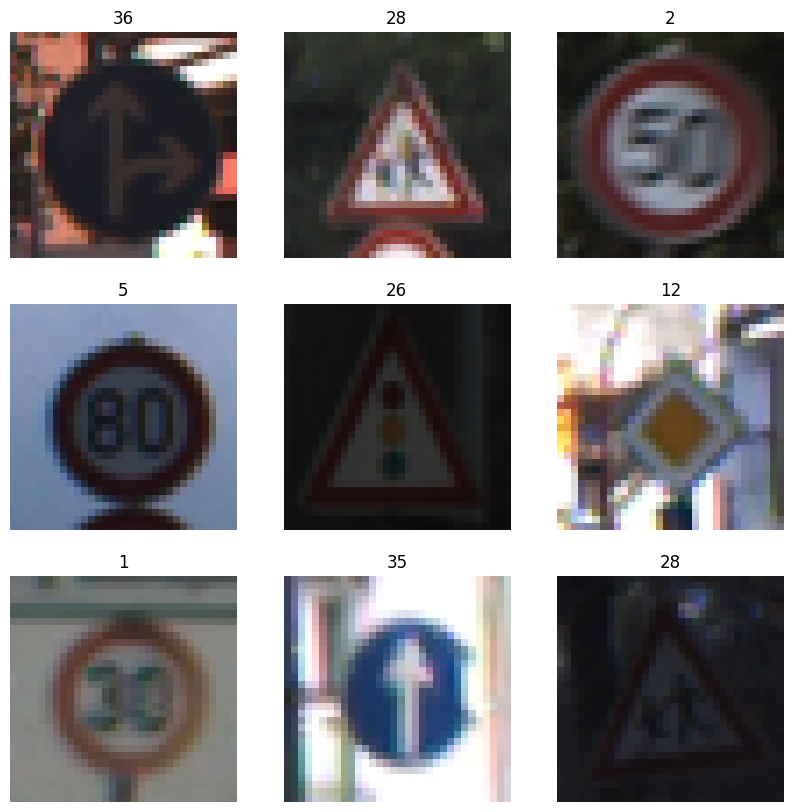

In [22]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(X_train[i])
  plt.title(y_train[i])
  plt.axis("off")

In [23]:
resize_and_rescale = tf.keras.Sequential([
    tf.keras.layers.Resizing(img_height, img_width),
    tf.keras.layers.Rescaling(1./255)
])

In [24]:
num_classes = 43

model = tf.keras.Sequential([
    resize_and_rescale,

    tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='same', input_shape=(img_height, img_width, 3)),
    tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same'),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2)),
    
    tf.keras.layers.Conv2D(filters=128, kernel_size=(3,3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(filters=256, kernel_size=(3,3), activation='relu', padding='same'),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2)),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(rate=0.5),

    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(rate=0.5),
    
    tf.keras.layers.Dense(num_classes, activation='softmax')
])


In [25]:
model.compile(
  optimizer='adam',
  loss='sparse_categorical_crossentropy',
  metrics=['accuracy'])

In [26]:
model.fit(
  X_train, y_train,
  validation_data=(X_val, y_val),
  epochs=10
)

Epoch 1/10
981/981 [==============================] - 20s 10ms/step - loss: 1.9721 - accuracy: 0.4234 - val_loss: 0.3627 - val_accuracy: 0.8979
Epoch 2/10
981/981 [==============================] - 9s 10ms/step - loss: 0.3254 - accuracy: 0.8995 - val_loss: 0.0534 - val_accuracy: 0.9866
Epoch 3/10
981/981 [==============================] - 9s 9ms/step - loss: 0.1328 - accuracy: 0.9617 - val_loss: 0.0353 - val_accuracy: 0.9911
Epoch 4/10
981/981 [==============================] - 10s 10ms/step - loss: 0.0813 - accuracy: 0.9762 - val_loss: 0.0287 - val_accuracy: 0.9921
Epoch 5/10
981/981 [==============================] - 12s 13ms/step - loss: 0.0650 - accuracy: 0.9822 - val_loss: 0.0150 - val_accuracy: 0.9954
Epoch 6/10
981/981 [==============================] - 10s 10ms/step - loss: 0.0574 - accuracy: 0.9840 - val_loss: 0.0161 - val_accuracy: 0.9967
Epoch 7/10
981/981 [==============================] - 13s 14ms/step - loss: 0.0456 - accuracy: 0.9883 - val_loss: 0.0186 - val_accuracy: 0.

In [27]:
y_test = pd.read_csv('/content/Test.csv')

labels = y_test["ClassId"].values
imgs = y_test["Path"].values

data=[]

with tf.device('/GPU:0'):
    for img in imgs:
        image = Image.open('/content/'+img)
        image = image.resize([img_height, img_width])
        data.append(np.array(image))

X_test=np.array(data)

In [28]:
model.evaluate(X_test, labels)

395/395 [==============================] - 2s 4ms/step - loss: 0.1195 - accuracy: 0.9771


[0.11954925954341888, 0.9771179556846619]